In [1]:
import pandas as pd
import numpy as np

In [2]:
d=pd.read_csv('/home/salmon/workspace/data/15MA inductive - burn/profile.txt',sep='\t')

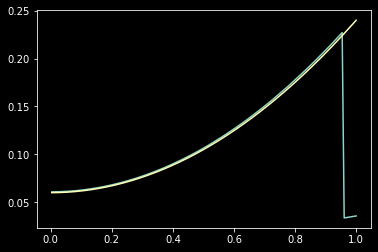

In [14]:
x=d["x"]
plt.plot(x,d["Dn"])
plt.plot(x,0.06*(1+3*x**2))

In [3]:
import sys
sys.path.append("/home/salmon/workspace/fytok/python")
sys.path.append("/home/salmon/workspace/fytok/external/SpDB/python")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fytok.Tokamak import Tokamak
from spdm.data.Collection import Collection
from spdm.data.File import File
from spdm.numerical.Function import Function
from spdm.util.logger import logger
from spdm.util.plot_profiles import plot_profiles

2021-04-09 13:20:44,399 DEBUG [spdm] /home/salmon/workspace/fytok/external/SpDB/python/spdm/numerical/Function.py:16:<module>: Using SciPy Version: 1.4.1


In [6]:
device = File("/home/salmon/workspace/fytok/data/mapping/ITER/imas/3/static/config.xml").entry

equilibrium = File(
        "/home/salmon/workspace/fytok/examples/data/NF-076026/geqdsk_550s_partbench_case1",
        # "/home/salmon/workspace/data/15MA inductive - burn/Increased domain R-Z/High resolution - 257x513/g900003.00230_ITER_15MA_eqdsk16VVHR.txt",
        # "/home/salmon/workspace/data/Limiter plasmas-7.5MA li=1.1/Limiter plasmas 7.5MA-EQDSK/Limiter_7.5MA_outbord.EQDSK",
        format="geqdsk").entry

tok = Tokamak({
        "radial_grid": {
            "axis": 128,
            "label": "rho_tor_norm"
        },
        "wall":  device.wall,
        "pf_active": device.pf_active,
        "equilibrium": {
            "vacuum_toroidal_field": equilibrium.vacuum_toroidal_field,
            "global_quantities": equilibrium.global_quantities,
            "profiles_1d": equilibrium.profiles_1d,
            "profiles_2d": equilibrium.profiles_2d,
            "coordinate_system": {"grid": {"dim1": 64, "dim2": 128}}
        },
        # "core_profiles":{ion": [{}]}
    })

rho_tor_norm = np.linspace(0, 1.0, 128)


2021-04-09 07:54:15,090 DEBUG [spdm] /home/salmon/workspace/fytok/external/SpDB/python/spdm/data/file/PluginXML.py:71:load_xml: Loading XML file from /home/salmon/workspace/fytok/data/mapping/ITER/imas/3/static/config.xml
2021-04-09 07:54:15,092 DEBUG [spdm] /home/salmon/workspace/fytok/external/SpDB/python/spdm/data/file/PluginXML.py:71:load_xml: Loading XML file from /home/salmon/workspace/fytok/data/mapping/ITER/imas/3/static/wall.xml
2021-04-09 07:54:15,093 DEBUG [spdm] /home/salmon/workspace/fytok/external/SpDB/python/spdm/data/file/PluginXML.py:71:load_xml: Loading XML file from /home/salmon/workspace/fytok/data/mapping/ITER/imas/3/static/pf_active.xml


In [53]:

r_ped = np.sqrt(0.88)
r_bdry=tok.equilibrium.profiles_1d.rho_tor[-1]
vpr=tok.equilibrium.profiles_1d.vprime
n_src = Function(rho_tor_norm, lambda x: 1e19 * np.exp(5.0*(x**2-1.0)))
diff =  Function(rho_tor_norm,
                [lambda r:r < r_ped, lambda r:r >= r_ped],
                [lambda x:0.5 + (x**4), lambda x: 0.11])

conv = -diff*rho_tor_norm * 1.385 / equilibrium.vacuum_toroidal_field.r0

tok.initialize({
    "r_ped": r_ped,  # \frac{\Phi}{\Phi_a}=0.88
    "electron": {
        "density": {
            "n0": Function(rho_tor_norm, np.full(rho_tor_norm.shape, 1e20)),
            "source": n_src,
            "diffusivity":  diff,
            "pinch": conv,
            "boundary_condition": {"value": 4.6e19}
        },
        "temperature": {
            "T0": 0.95e19,
            "profile": lambda r: (1-r**2)**2,
        }}
})


In [54]:
tok.update(transport_solver={})

2021-04-09 08:05:21,924 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/Tokamak.py:278:update: time=0.0  iterator step 0/1
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          9.24e-05       0.00e+00          128             0       
Solved in 1 iterations, number of nodes 128. 
Maximum relative residual: 9.24e-05 
Maximum boundary residual: 0.00e+00
2021-04-09 08:05:22,124 INFO [spdm] : Solve transport equations: Electron density: Success 


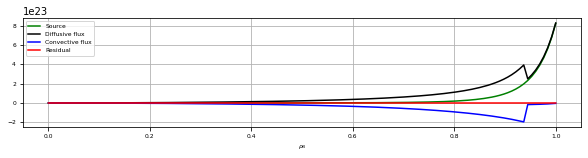

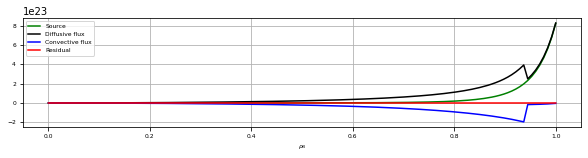

In [55]:
plot_profiles([  
[
    (tok.core_profiles.electrons.n_s_exp_flux,    {"color": "green", "label": r"Source"}),
    (tok.core_profiles.electrons.n_diff_flux,     {"color": "black", "label": r"Diffusive flux"}),
    (tok.core_profiles.electrons.n_conv_flux,     {"color": "blue",  "label": r"Convective flux"}),
    (tok.core_profiles.electrons.n_residual,      {"color": "red",   "label": r"Residual"}),
]
], x_axis=(tok.core_profiles.electrons.density.x,   {"label": r"$\rho_{N}$"}),  # x axis,
grid=True) 

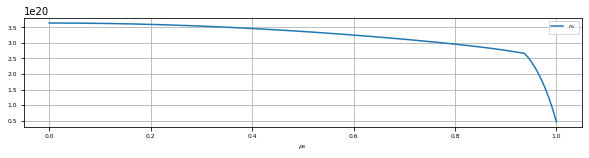

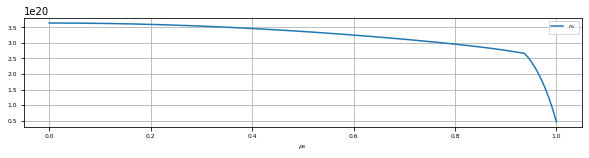

In [56]:
plot_profiles(
    [  
        (tok.core_profiles.electrons.density,             r"$n_{e}$"),
    ],
    x_axis=(tok.core_profiles.electrons.density.x,   {"label": r"$\rho_{N}$"}),  # x axis,
    grid=True) 

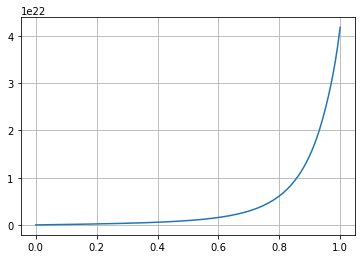

In [57]:
n_src = Function(rho_tor_norm, lambda x: 1.0e20 * np.exp(5.0*(x**2-1.0)))

plt.plot(rho_tor_norm,Function(rho_tor_norm,vpr(rho_tor_norm)*n_src*r_bdry).antiderivative)
plt.grid()